In [1]:
import torch
import pandas as pd
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
import cv2

from transformers import AutoTokenizer, AutoModelForSequenceClassification, DistilBertForSequenceClassification, AutoModelForSeq2SeqLM
from tqdm import tqdm
from torchvision import models
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from keras.preprocessing import image
from torchmetrics.classification import MultilabelF1Score
from sklearn.metrics import average_precision_score, ndcg_score

d:\Administrator\anaconda3\envs\cv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings("ignore")

In [3]:
genres = ["Crime", "Thriller", "Fantasy", "Horror", "Sci-Fi", "Comedy", "Documentary", "Adventure", "Film-Noir", "Animation", "Romance", "Drama", "Western", "Musical", "Action", "Mystery", "War", "Children\'s"]
mapping = {}
for i in range(len(genres)):
    mapping[i] = genres[i]
mapping

{0: 'Crime',
 1: 'Thriller',
 2: 'Fantasy',
 3: 'Horror',
 4: 'Sci-Fi',
 5: 'Comedy',
 6: 'Documentary',
 7: 'Adventure',
 8: 'Film-Noir',
 9: 'Animation',
 10: 'Romance',
 11: 'Drama',
 12: 'Western',
 13: 'Musical',
 14: 'Action',
 15: 'Mystery',
 16: 'War',
 17: "Children's"}

In [4]:
trainset = pd.read_csv('dataset/trainset.csv')
testset = pd.read_csv('dataset/testset.csv')
trainset.label = trainset.label.apply(lambda x: eval(x))
testset.label = testset.label.apply(lambda x: eval(x))
trainset.img_path = trainset.img_path.apply(lambda x: x.replace('\\', '/'))
testset.img_path = testset.img_path.apply(lambda x: x.replace('\\', '/'))

In [5]:
print(len(trainset), len(testset))

3106 777


In [6]:
def load_state_dict(checkpoint_path, use_ema=False, num_classes=1000):
    if checkpoint_path and os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        state_dict_key = 'state_dict'
        if isinstance(checkpoint, dict):
            if use_ema and 'state_dict_ema' in checkpoint:
                state_dict_key = 'state_dict_ema'
        if state_dict_key and state_dict_key in checkpoint:
            new_state_dict = OrderedDict()
            for k, v in checkpoint[state_dict_key].items():
                # strip `module.` prefix
                name = k[7:] if k.startswith('module') else k
                new_state_dict[name] = v
            state_dict = new_state_dict
        else:
            state_dict = checkpoint
#         _logger.info("Loaded {} from checkpoint '{}'".format(state_dict_key, checkpoint_path))
#         if num_classes != 1000:
#             # completely discard fully connected for all other differences between pretrained and created model
#             del state_dict['head' + '.weight']
#             del state_dict['head' + '.bias']

        return state_dict
    else:
#         _logger.error("No checkpoint found at '{}'".format(checkpoint_path))
        raise FileNotFoundError()


def load_for_transfer_learning(model, checkpoint_path, use_ema=False, strict=False, num_classes=1000):
    state_dict = load_state_dict(checkpoint_path, use_ema, num_classes)
    model.load_state_dict(state_dict, strict=strict)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
from models.t2t_vit import *

tokenizer1 = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model1 = DistilBertForSequenceClassification .from_pretrained("distilbert-base-uncased", problem_type="multi_label_classification", num_labels=18)
model1.config.id2label = mapping

tokenizer2 = AutoTokenizer.from_pretrained("dduy193/plot-classification")
model2 = AutoModelForSequenceClassification.from_pretrained("dduy193/plot-classification")
model2.config.id2label = mapping

model3 = T2t_vit_14(img_size=224, num_classes=12)
model3.fc = torch.nn.Linear(2048, len(genres))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1.to(device)
model2.to(device)
model3.to(device)
device

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adopt performer encoder for tokens-to-token


device(type='cuda')

In [9]:
class Multimodal(torch.nn.Module):
    def __init__(self, model1, model2, model3):
        super().__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        self.fc1 = torch.nn.Linear(18, 18)
        self.fc2 = torch.nn.Linear(18, 18)
        self.fc3 = torch.nn.Linear(12, 18)

    def forward(self, 
                title_input_ids, title_attention_mask,
                plot_input_ids, plot_attention_mask,
                image_input):
        title_output = self.model1(title_input_ids, title_attention_mask)
        plot_output = self.model2(plot_input_ids, plot_attention_mask)
        image_output = self.model3(image_input)

        title_output = self.fc1(title_output.logits)
        plot_output = self.fc2(plot_output.logits)
        image_output = self.fc3(image_output)
        
        output = torch.add(title_output, plot_output)
        output = torch.add(output, image_output)
        return output

In [10]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, 
                 tokenizer1, tokenizer2, 
                 max_len1=64, max_len2=256,
                 device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
        self.df = df
        self.tokenizer1 = tokenizer1
        self.tokenizer2 = tokenizer2
        self.max_len1 = max_len1
        self.max_len2 = max_len2
        self.device = device
        self.transform = v2.Compose([
            v2.Resize((224, 224)),
            v2.ToTensor(),
            v2.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        title = row['title']
        # Truncate title if it is too long
        if len(title) > self.max_len1:
            title = title[:self.max_len1]

        plot = row['plot']
        # Truncate plot if it is too long
        if len(plot) > self.max_len2:
            plot = plot[:self.max_len2]

        label = row['label']
        title_encoding = self.tokenizer1(title, truncation=True, padding='max_length', max_length=self.max_len1, return_tensors='pt')
        plot_encoding = self.tokenizer2(plot, truncation=True, padding='max_length', max_length=self.max_len2, return_tensors='pt')
        
        image_path = 'dataset/' + row['img_path']
        if os.path.exists(image_path):
            image_input = image.load_img(image_path)
            image_input = self.transform(image_input)
        else:
            image_input = torch.zeros((3, 224, 224))
        
        return {
            'title': title,
            'plot': plot,
            'title_input_ids': title_encoding['input_ids'].squeeze(),
            'title_attention_mask': title_encoding['attention_mask'].squeeze(),
            'plot_input_ids': plot_encoding['input_ids'].squeeze(),
            'plot_attention_mask': plot_encoding['attention_mask'].squeeze(),
            'image_input': image_input,
            'label': torch.FloatTensor(label)
        }

In [11]:
trainset.head()

,title,img_path,label,plot
0,Washington Square (1997),ml1m-images/1650.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",Washington Square is a 1997 American film abou...
1,"Net, The (1995)",ml1m-images/185.jpg,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Net is a 1995 American film directed by James ...
2,Batman Returns (1992),ml1m-images/1377.jpg,"[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...",Batman returns to the Batman universe after a ...
3,"Boys from Brazil, The (1978)",ml1m-images/3204.jpg,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","The movie Boys from Brazil, The (1978) is a ro..."
4,Dear Jesse (1997),ml1m-images/1901.jpg,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",Dear Jesse is a 1997 American drama film about...


In [12]:
trainset = CustomDataset(df=trainset, tokenizer1=tokenizer1, tokenizer2=tokenizer2,
                   max_len1=64, max_len2=256,
                   device=device)
testset = CustomDataset(df=testset, tokenizer1=tokenizer1, tokenizer2=tokenizer2,
                  max_len1=64, max_len2=256,
                  device=device)

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Title:  McHale's Navy (1997)
Plot:  McHale's Navy is a movie about a man named John McHale who is a Navy SEAL who is tasked with defending a US Navy vessel in the Pacific Ocean. The movie follows his journey as he navigates the dangerous waters of the Pacific Ocean and learns about the dange
Label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])


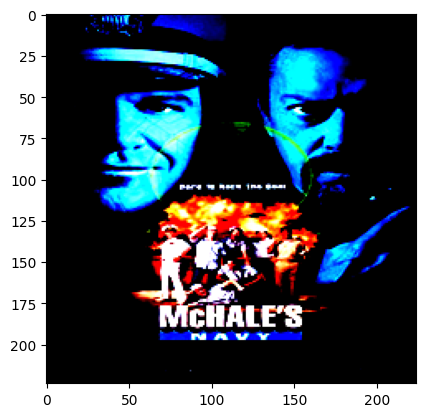

In [14]:
sample = next(iter(testloader))

# First sample of the batch
print('Title: ', sample['title'][3])
print('Plot: ', sample['plot'][3])
print('Label: ', sample['label'][3])
plt.imshow(sample['image_input'][3].permute(1, 2, 0))

In [15]:
model = Multimodal(model1, model2, model3)
model.to(device)
device

# Freeze layers
for param in model.model2.parameters():
    param.requires_grad = False
    
model

Multimodal(
  (model1): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): DistilBertSdpaAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ff

In [16]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2e-5)

In [17]:
history_loss = []
history_f1 = []
history_mapk = []
history_ndcg = []
def train(epoch):
    model.train()
    f1 = MultilabelF1Score(num_labels=18, threshold=0.5, average='macro')
    f1.to(device)

    actual = []
    predicted = []
    for _, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
        title_input_ids = data['title_input_ids'].to(device)
        title_attention_mask = data['title_attention_mask'].to(device)
        plot_input_ids = data['plot_input_ids'].to(device)
        plot_attention_mask = data['plot_attention_mask'].to(device)
        image_input = data['image_input'].to(device)
        label = data['label'].to(device)

        optimizer.zero_grad()
        outputs = model(
            title_input_ids, title_attention_mask,
            plot_input_ids, plot_attention_mask,
            image_input
        )
        
        loss = loss_fn(outputs, label)
        loss.backward()
        optimizer.step()

        f1.update(outputs.sigmoid(), label)
        
        probabilities = outputs.sigmoid().cpu().detach().numpy()

        actual.append(label.cpu().detach().numpy())
        predicted.append(probabilities)
    actual_flat = np.vstack(actual)
    predicted_flat = np.vstack(predicted)
    maps = average_precision_score(actual_flat, predicted_flat, average="samples")
    
    ndcg = ndcg_score(actual_flat, predicted_flat)
    
    print(f'Epoch: {epoch}, Train Loss: {loss.item()}, Train F1: {f1.compute().item()}, Train MAP: {maps}, Train NDCG: {ndcg}')
    history_loss.append(loss.item())
    history_f1.append(f1.compute().item())
    history_mapk.append(maps)
    history_ndcg.append(ndcg)

In [18]:
for epoch in range(32):
    train(epoch)

100%|██████████| 173/173 [01:02<00:00,  2.77it/s]


Epoch: 0, Train Loss: 0.7074189782142639, Train F1: 0.11775866895914078, Train MAP: 0.2605932332675875, Train NDCG: 0.4481084165681047


100%|██████████| 173/173 [01:00<00:00,  2.85it/s]


Epoch: 1, Train Loss: 0.45910975337028503, Train F1: 0.12072207778692245, Train MAP: 0.37014358686070925, Train NDCG: 0.5371988608358069


 58%|█████▊    | 101/173 [00:34<00:24,  2.91it/s]


KeyboardInterrupt: 

In [ ]:
# Save model
torch.save(model.state_dict(), 'partially_frozen_multimodel.pt')

In [ ]:
# Visualize
plt.plot(history_loss)
plt.plot(history_f1)
plt.plot(history_mapk)
plt.plot(history_ndcg)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'F1-Macro', 'MAP', 'NDCG'], loc='upper left')
plt.show()

In [ ]:
# Validation
def test(testing_loader):
    model.eval()
    f1 = MultilabelF1Score(num_labels=18, threshold=0.5, average='macro')
    f1.to(device)

    actual = []
    predicted = []

    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0), total=len(testing_loader)):
            title_input_ids = data['title_input_ids'].to(device)
            title_attention_mask = data['title_attention_mask'].to(device)
            plot_input_ids = data['plot_input_ids'].to(device)
            plot_attention_mask = data['plot_attention_mask'].to(device)
            image_input = data['image_input'].to(device)
            label = data['label'].to(device)

            outputs = model(
                title_input_ids, title_attention_mask,
                plot_input_ids, plot_attention_mask,
                image_input
            )
            f1.update(outputs.sigmoid(), label)
        
        probabilities = outputs.sigmoid().cpu().detach().numpy()

        actual.append(label.cpu().detach().numpy())
        predicted.append(probabilities)
    actual_flat = np.vstack(actual)
    predicted_flat = np.vstack(predicted)
    mapp = average_precision_score(actual_flat, predicted_flat, average="samples")
    
    ndcg = ndcg_score(actual_flat, predicted_flat)
    
    print(f'Test F1: {f1.compute().item()}, Test MAP: {mapp}, Test NDCG: {ndcg}')

In [ ]:
test(testloader)

In [ ]:
def inference(title, plot, image_input, tokenizer1=tokenizer1, tokenizer2=tokenizer2, model=model, genres=genres, device=device):
    title_input = tokenizer1(title, return_tensors='pt', padding=True, truncation=True)
    title_input_ids = title_input['input_ids'].to(device)
    title_attention_mask = title_input['attention_mask'].to(device)

    plot_input = tokenizer2(plot, return_tensors='pt', padding=True, truncation=True)
    plot_input_ids = plot_input['input_ids'].to(device)
    plot_attention_mask = plot_input['attention_mask'].to(device)

    image_input = image_input.to(device)
    print(title)
    print(plot)
    plt.imshow(image_input.permute(1, 2, 0).cpu().detach().numpy())

    output = model(title_input_ids, title_attention_mask, plot_input_ids, plot_attention_mask, image_input.unsqueeze(0))
    output = torch.sigmoid(output)
    output = output.cpu().detach().numpy()
    output = np.where(output > 0.5, 1, 0)
    output = output.squeeze()
    output = np.where(output == 1)[0]
    output = [genres[i] for i in output]
    return output

In [ ]:
inference(sample['title'][1], sample['plot'][1], sample['image_input'][1])